In [ ]:
import os 
import pathlib
import pickle as pkl
import cloudpickle 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, RocCurveDisplay, average_precision_score, precision_recall_curve, PrecisionRecallDisplay, balanced_accuracy_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
pd.set_option('display.max_columns', None)
from bill_classification import *

In [2]:
X_train, X_test, y_train, y_test, y_classes, bill_ls = split_features(
    feature_path = "../data/preprocessed/features.pkl", 
    block_path = "../data/preprocessed/block_array.pkl")

/work/DPF_exam/src/bill_classification.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  block_df_split[[(col+"_s"), (col+"_n"), (col+"_o")]] = pd.DataFrame(block_df[col].to_list())
/work/DPF_exam/src/bill_classification.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  block_df_split[[(col+"_s"), (col+"_n"), (col+"_o")]] = pd.DataFrame(block_df[col].to_list())
/work/DPF_exam/src/bill_classification.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [3]:
ct = preprocess_ct()

In [4]:
ct.fit_transform(X_train)

array([[1.0, 0.0, 0.0, ..., 0.0, 0.0,
        'a bill for an act relating to the entrepreneur investment awards program'],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0,
        'establishes trenton capital city aid program appropriates million'],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0,
        'relative to potentially dangerous and vicious dogs'],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0,
        'an act to renumber and amend d to amend g and intro and to create a bt at m and d of the statutes relating to student achievement guarantee in education program contracts'],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0,
        'authorizes certain municipalities to impose a tax on the storage of empty shipping containers to fund redevelopment plan activities'],
       [0.0, 1.0, 0.0, ..., 0.0, 0.0,
        'relativerelative to property tax exemptions for rental properties in the town of truro restricted as affordable housing revenue local approval received']],
      shape=(36736, 426), dtype=object)

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22490
           1       0.27      0.53      0.36      3061

    accuracy                           0.77     25551
   macro avg       0.60      0.67      0.61     25551
weighted avg       0.85      0.77      0.80     25551

balanced accuracy: 0.667
roc auc score: 0.667


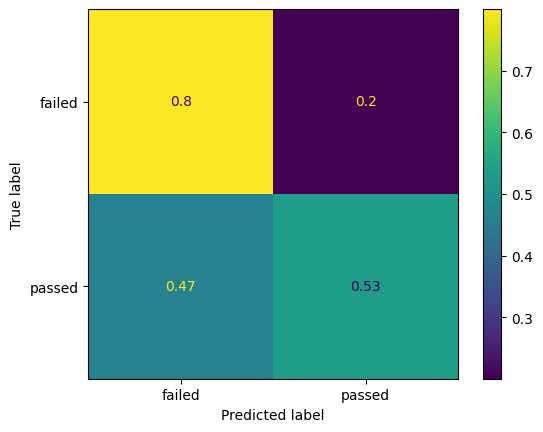

In [78]:
y_pred_nt = clf_pipeline_LSVC_notext.predict(X_test)
print(classification_report(y_test, y_pred_nt))
print(f"balanced accuracy: {round(balanced_accuracy_score(y_test, y_pred_nt), 4)}")
print(f"roc auc score: {round(roc_auc_score(y_test, y_pred_nt, average="weighted"), 4)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nt, display_labels=["failed", "passed"], normalize="true")

In [80]:
feature_coefs = pd.DataFrame(pd.Series(feature_names_notext).str.split("__", expand=True))
feature_coefs.rename(columns={0:"transformer", 1: 'feature'}, inplace=True)
feature_coefs["coef"] = LSVC_coef_notext.reshape(-1,)
print(feature_coefs.value_counts("transformer"))
#subset counts
feature_coefs_count = feature_coefs[feature_coefs["transformer"]=="count"]
feature_coefs_count[["Block", "position"]] = feature_coefs_count["feature"].str.split("_", expand=True)[[1,2]]

transformer
count    408
num        9
cat        6
bin        2
Name: count, dtype: int64


/tmp/ipykernel_62937/2634969928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_coefs_count[["Block", "position"]] = feature_coefs_count["feature"].str.split("_", expand=True)[[1,2]]
/tmp/ipykernel_62937/2634969928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_coefs_count[["Block", "position"]] = feature_coefs_count["feature"].str.split("_", expand=True)[[1,2]]


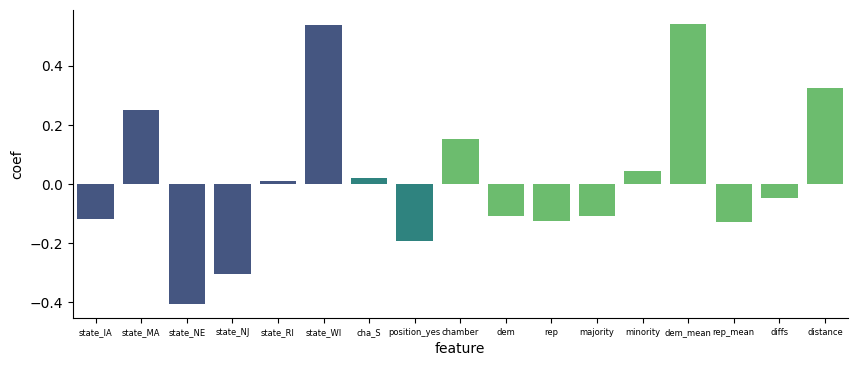

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(feature_coefs[feature_coefs["transformer"].isin(["num", "cat", "bin"])], 
            x="feature", y="coef", hue="transformer", legend=None, palette="viridis")
sns.despine()
plt.tick_params(axis="x", labelsize=6)